<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/4-training-models/05_softnax_regression_implementation_with_batch_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Softmax Regression implementation with Batch Gradient Descent

Let's implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn).

##Setup

In [43]:
# Common imports
import numpy as np
import numpy.random as rnd
import os

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn import datasets


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

##Traing and test set prepation

Let's start by loading the data.

In [44]:
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [45]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"] 

We need to add the bias term for every instance $(x_0=1)$:

In [46]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]
X_with_bias[:5]

array([[1. , 1.4, 0.2],
       [1. , 1.4, 0.2],
       [1. , 1.3, 0.2],
       [1. , 1.5, 0.2],
       [1. , 1.4, 0.2]])

The easiest option to split the dataset into a training set, a validation set and a test set would be to use Scikit-Learn's `train_test_split()` function, but the point of this exercise is to try understand the algorithms by implementing them manually. 

So here is one possible implementation:

In [47]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(test_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

x_train = X_with_bias[rnd_indices[: train_size]]
y_train = y[rnd_indices[: train_size]]

x_valid = X_with_bias[rnd_indices[train_size: - test_size]]
y_valid = y[rnd_indices[train_size: - test_size]]

x_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for ay given instance is a one-hot vector). 

Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance:

In [48]:
def to_one_hot(y):
  n_classes = y.max() + 1
  m = len(y)
  y_one_hot = np.zeros((m, n_classes))
  y_one_hot[np.arange(m), y] = 1
  return y_one_hot

Let's test this function on the first 10 instances:

In [49]:
y_train[:10]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

In [50]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

Looks good, so let's create the target class probabilities matrix for the training set and the test set:

In [51]:
y_train_one_hot = to_one_hot(y_train)
y_valid_one_hot = to_one_hot(y_valid)
y_test_one_hot = to_one_hot(y_test)

##Softmax function

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [52]:
def softmax(logits):
  exps = np.exp(logits)
  exp_sums = np.sum(exps, axis=1, keepdims=True)
  return exps / exp_sums

We are almost ready to start training. Let's define the number of inputs and outputs:

In [53]:
n_inputs = x_train.shape[1]          # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))  # == 3 (3 iris classes)

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function(Cross-entropy):

$J(\mathbf{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

In [54]:
eta = 0.01
n_iterations = 5001
m = len(x_train)
epsilon = 1e-7

theta = np.random.randn(n_inputs, n_outputs)

In [55]:
for iteration in range(n_iterations):
  logits = x_train.dot(theta)
  y_prob = softmax(logits)
  # calculate loss
  loss = -np.mean(np.sum(y_train_one_hot * np.log(y_prob + epsilon), axis=1))
  error = y_prob - y_train_one_hot
  if iteration % 500 == 0:
    print(iteration, loss)
  # calculate  gradient
  gradients = 1 / m * x_train.T.dot(error)
  theta = theta - eta * gradients

0 3.707721415839796
500 0.7673305751239122
1000 0.6412154261885891
1500 0.5660236716079858
2000 0.515464311918938
2500 0.47855496793722874
3000 0.4500407743209087
3500 0.4271043176384924
4000 0.4080942711875561
4500 0.39197317452300495
5000 0.3780525972134107


And that's it! The Softmax model is trained. Let's look at the model parameters:

In [56]:
theta

array([[ 2.37446439, -1.59293044, -3.6002626 ],
       [-0.60647941,  0.47861577,  0.23254471],
       [-0.95539619,  0.41605589,  2.45609216]])

Let's make predictions for the validation set and check the accuracy score:

In [57]:
logits = x_valid.dot(theta)
y_prob = softmax(logits)
y_predict = np.argmax(y_prob, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.8333333333333334

Well, this model looks pretty good. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). 

Also, let's try increasing the learning rate `eta`.

In [58]:
eta = 0.1
n_iterations = 5001
m = len(x_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

theta = np.random.randn(n_inputs, n_outputs)

In [59]:
for iteration in range(n_iterations):
  logits = x_train.dot(theta)
  y_prob = softmax(logits)
  # calculate loss
  xentropy_loss = -np.mean(np.sum(y_train_one_hot * np.log(y_prob + epsilon), axis=1))
  l2_loss = 1 / 2 * np.sum(np.square(theta[1:]))
  loss = xentropy_loss + alpha * l2_loss
  error = y_prob - y_train_one_hot
  if iteration % 500 == 0:
    print(iteration, loss)
  # calculate  gradient
  gradients = 1 / m * x_train.T.dot(error) * np.r_[np.zeros([1, n_outputs]), alpha * theta[1:]]
  theta = theta - eta * gradients

0 4.255851639709504
500 113645.95549724023
1000 4167555033731.0815
1500 1.5284486137398726e+20
2000 5.605577243652124e+27
2500 2.055842502788814e+35
3000 7.539791555025227e+42
3500 2.7652145831265307e+50
4000 1.0141409924839813e+58
4500 3.7193567505112914e+65
5000 1.3640721300191863e+73


Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? 

Let's find out:

In [60]:
logits = x_valid.dot(theta)
y_prob = softmax(logits)
y_predict = np.argmax(y_prob, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.5

Cool, perfect accuracy! We probably just got lucky with this validation set, but still, it's pleasant.

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [61]:
eta = 0.1
n_iterations = 5001
m = len(x_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

theta = np.random.randn(n_inputs, n_outputs)

In [62]:
for iteration in range(n_iterations):
  logits = x_train.dot(theta)
  y_prob = softmax(logits)

  # calculate loss
  xentropy_loss = -np.mean(np.sum(y_train_one_hot * np.log(y_prob + epsilon), axis=1))
  l2_loss = 1 / 2 * np.sum(np.square(theta[1:]))
  loss = xentropy_loss + alpha * l2_loss
  error = y_prob - y_train_one_hot

  # calculate  gradient
  gradients = 1 / m * x_train.T.dot(error) * np.r_[np.zeros([1, n_outputs]), alpha * theta[1:]]
  theta = theta - eta * gradients

  # apply eraly stoping
  logits = x_valid.dot(theta)
  y_prob = softmax(logits)
  xentropy_loss = -np.mean(np.sum(y_valid_one_hot * np.log(y_prob + epsilon), axis=1))
  l2_loss = 1 / 2 * np.sum(np.square(theta[1:]))
  loss = xentropy_loss + alpha * l2_loss

  if iteration % 500 == 0:
    print(iteration, loss)
  if loss < best_loss:
    best_loss = loss
  else:
    print(iteration - 1, best_loss)
    print(iteration, loss, "early stopping!")
    break

0 1.7091130800554852
7 1.704384437544568
8 1.7045739312032437 early stopping!


In [63]:
logits = x_valid.dot(theta)
y_prob = softmax(logits)
y_predict = np.argmax(y_prob, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.5

Still perfect, but faster.

Now let's plot the model's predictions on the whole dataset:

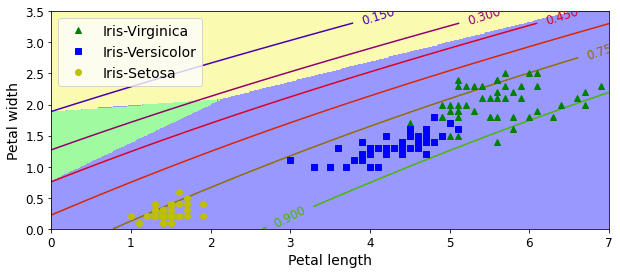

In [64]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

And now let's measure the final model's accuracy on the test set:

In [65]:
logits = x_test.dot(theta)
y_prob = softmax(logits)
y_predict = np.argmax(y_prob, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.36666666666666664

Our perfect model turns out to have slight imperfections. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.